In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import numpy as np
import librosa
import IPython.display as ipd
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from birds_analysis import analyze_audio, plot_librosa_stft, get_class_dataset, sample_audio_clip, multiclass_metrics, get_F1_micro, sample_audio_clip
from birds_utils import Dataset, get_pytorch_model, validate_model_acc_loss, validate_model_loss_detail, get_pytorch_model_all_conv, validate, multilabel_metrics, get_bin_audio

In [ ]:
window_size = 1024
sr = 22050

n_classes = 264
train_files = np.load(f'train_files_{sr}_{n_classes}_librosa.npy')
train_labels = np.load(f'train_labels_{sr}_{n_classes}_librosa.npy')
val_files = np.load(f'val_files_{sr}_{n_classes}_librosa.npy')
val_labels = np.load(f'val_labels_{sr}_{n_classes}_librosa.npy')
classes = np.load(f'./models/classes_{n_classes}.npy')

# train_files = [f.replace('npy_44100', 'npy_22050').replace('npy', 'bin') for f in train_files]
# val_files = [f.replace('npy_44100', 'npy_22050').replace('npy', 'bin') for f in val_files]

# Import model and load weights

In [ ]:
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 1}

min_std = 0.5
duration = 5

In [ ]:
saved_weights = './models/model_ambient_librosa_264_0.677.pth'
saved_weights = './models/model_ambient_librosa_264_0.73.pth'


window_size = 1024
model = get_pytorch_model_all_conv(window_size, resnet='resnet18', pretrained=True, n_classes=n_classes, init_fourier=True, train_fourier=False).to(device)
state_dict = torch.load(saved_weights, map_location=torch.device('cpu'))

model.load_state_dict(state_dict)
_ = model.eval()

In [ ]:
std_stats = np.load('files_std_data_librosa.npy', allow_pickle=True).item()

In [ ]:
classes_test = []
for file in std_stats:
    classes_test.append(file.split('/')[-2])
len(np.unique(classes_test))

# Cargo generator y testeo metrica

In [ ]:
val_files_large = []
for file in val_files:
    if std_stats[file]['size'] >= sr*duration:
        val_files_large.append(file)

In [ ]:
len(val_files) - len(val_files_large)

In [11]:
params_val = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0,
              'timeout': 0
             }
N = 1


validation_set = Dataset(list(val_files_large)*N, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=False, max_tries=0)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

In [12]:
# criterion = torch.nn.BCEWithLogitsLoss()
# avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)

# 0.677             : 67/67 - val loss: 0.009417260065674782, val F1 micro: 0.6690959930419922 val acc: 0.5898196101188664
# 0.677, max_tries=0: 64/64 - val loss: 0.011891837231814861, val F1 micro: 0.5977628827095032 val acc: 0.49518162012100226
# 0.730             : 64/64 - val loss: 0.010323731228709221, val F1 micro: 0.7332955598831177 val acc: 0.6399802565574646
# 0.730, max_tries=0: 64/64 - val loss: 0.012852098792791367, val F1 micro: 0.6559832096099854 val acc: 0.5411415696144104


In [13]:
validation_set.stats

{'noise': 0,
 'noise+signal': 0,
 'signal': 0,
 'passband_noise': 0,
 'short_file': 0}

In [14]:
# plt.plot(X[0,0])

In [15]:
for X, y in validation_generator:
    print(X.shape, y.shape)
    break
_, y_pred = model(X.to(device))

torch.Size([64, 1, 110250]) torch.Size([64, 264])
torch.Size([64, 512, 427])


In [16]:
from sklearn.metrics import f1_score
TP, FP, FN, micro_F1, total, T_total = multilabel_metrics(y_pred, y.to(device))
print(micro_F1.cpu().item(), f1_score(y, y_pred.cpu()>0, average='micro'))

0.7047619223594666 0.7047619047619048


In [17]:
TP.sum()/T_total, TP.sum()/total

(tensor(0.5781, device='cuda:0'), tensor(0.5781, device='cuda:0'))

./dataset/bin_22050_librosa/balori/XC175541.mp3.bin
torch.Size([1, 512, 427])
balori 0.99, osprey 0.0, sora 0.0, blujay 0.0, normoc 0.0, reevir1 0.0, amegfi 0.0, yebfly 0.0, easblu 0.0, carwre 0.0, moudov 0.0, scatan 0.0, logshr 0.0, pinwar 0.0, belkin1 0.0, tuftit 0.0, saypho 0.0, greyel 0.0, grycat 0.0, eawpew 0.0, grtgra 0.0, swahaw 0.0, grcfly 0.0, warvir 0.0, chswar 0.0, veery 0.0, purfin 0.0, yetvir 0.0, blugrb1 0.0, robgro 0.0, houwre 0.0, lesyel 0.0, shshaw 0.0, norwat 0.0, fiscro 0.0, palwar 0.0, bulori 0.0, comnig 0.0, reshaw 0.0, buggna 0.0, aldfly 0.0, rethaw 0.0, amered 0.0, boboli 0.0, hoowar 0.0, westan 0.0, brnthr 0.0, killde 0.0, fiespa 0.0, cowscj1 0.0, gryfly 0.0, spotow 0.0, bkhgro 0.0, grbher3 0.0, comgra 0.0, linspa 0.0, wilsni1 0.0, plsvir 0.0, leafly 0.0, wilfly 0.0, pingro 0.0, camwar 0.0, bkbwar 0.0, foxspa 0.0, cliswa 0.0, sagthr 0.0, semplo 0.0, vigswa 0.0, moublu 0.0, yelwar 0.0, gnwtea 0.0, larspa 0.0, whbnut 0.0, calqua 0.0, doccor 0.0, canwre 0.0, wesblu

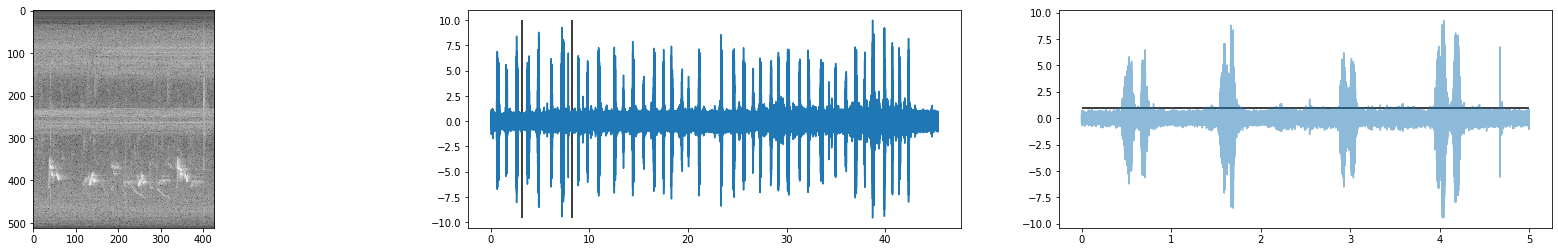

from: 3.1896598639455784, to: 8.189659863945579, std_thres: 0.9604330973925659, std_min: 0.3099968167542397, clip_std:1.0965074122853253


1.0965074122853253

In [17]:
TEST_FILE = './dataset/bin_22050_librosa/banswa/XC138517.mp3.bin'
TEST_FILE = './dataset/bin_22050_librosa/balori/XC175541.mp3.bin' # Grillos
audio = get_bin_audio(TEST_FILE) 
# audio = audio + 1*get_ambient_noise(len(audio), sr)
print(TEST_FILE)
audio_sample, fr, to = analyze_audio(model, audio, classes, sr, duration=5, min_std=None,  device=device, add_noise=False)

# model, audio, cl_idx, classes, sr, duration, min_std, device
audio_sample.std()

In [375]:
from birds_utils import get_pytorch_model_mel

In [376]:
from torch import nn
model_mel = get_pytorch_model_mel(window_size=2048, resnet='resnet18', pretrained=True, n_classes=n_classes, init_fourier=True, train_fourier=False).to(device)

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [384]:
for X, y in validation_generator:
    print(X.shape, y.shape)
    break

torch.Size([64, 1, 110250]) torch.Size([64, 264])


In [385]:
stft_model, spec, spec_db, y_pred = model_mel(X.to(device).float())

In [390]:
# spec_db.shape

In [391]:
# stft_model, spec, spec_db, y_pred = model_mel(torch.from_numpy(audio.reshape(1,1,-1)).to(device).float())
stft_model, spec, spec_db, y_pred = model_mel(X.to(device).float())
stft_model = stft_model.detach().cpu().squeeze(0).numpy()
spec_numpy = spec.squeeze(dim=0).cpu().detach().numpy()
spec_db = spec_db.squeeze(dim=0).cpu().detach().numpy()

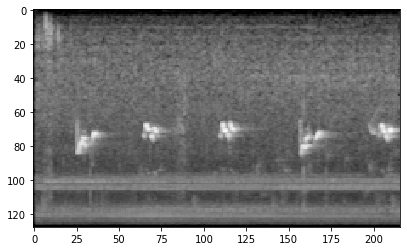

In [399]:
plt.figure(figsize=(30,4))
plt.imshow(librosa.power_to_db(librosa.feature.melspectrogram(audio[:sr*5])), cmap='gray')

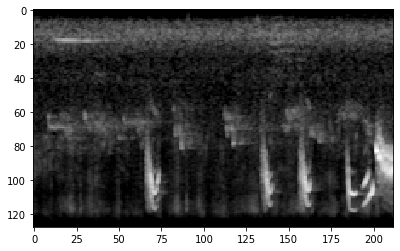

In [398]:
plt.figure(figsize=(30,4))
plt.imshow(spec_db[4], cmap='gray')
# plt.figure(figsize=(30,4))
# plt.imshow(amplitude_to_db(spec_numpy), cmap='gray')
# plt.figure(figsize=(30,4))
# plt.imshow(spec_db, cmap='gray')
# plt.figure(figsize=(30,4))
# plt.imshow(librosa.amplitude_to_db(np.sqrt(stft_model)), cmap='gray')

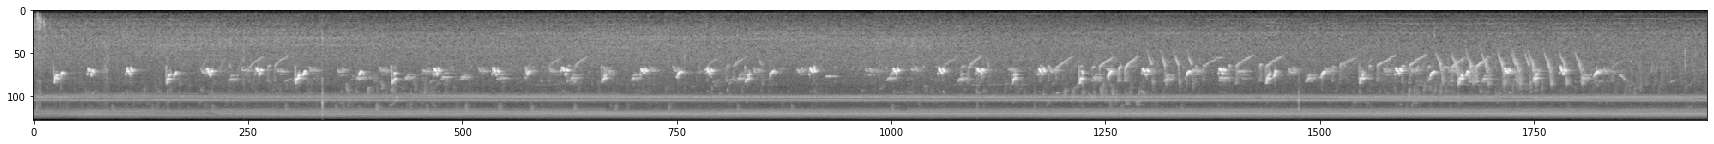

In [247]:
np.abs(stft).max(), np.abs(stft).min(), audio.std()

(2218.3818, 1.367902e-06, 0.9999999999999996)

In [248]:
np.sqrt(np.abs(stft_model)).max(), np.sqrt(np.abs(stft_model)).min()

(2218.346, 7.258239e-06)

In [249]:
stft_model.shape

(1025, 1952)

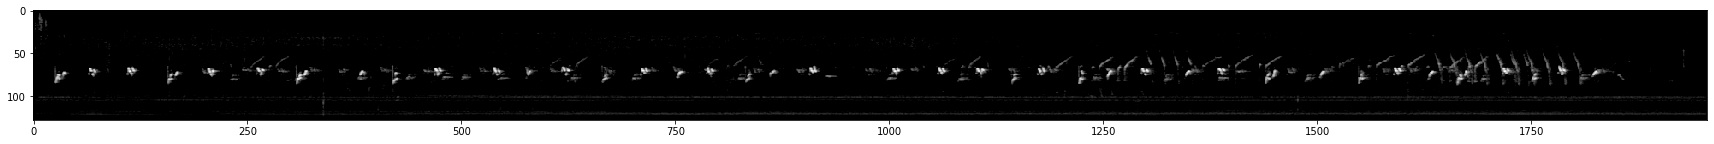

In [254]:
mel_filters = librosa.filters.mel(sr, 2048)
stft = librosa.stft(audio)
# mel_spec = librosa.feature.melspectrogram(audio, n_fft=2048)
mel_spec = mel_filters.dot(np.abs(stft)**2)
mel_mod = librosa.amplitude_to_db(mel_spec)
plt.figure(figsize=(30,4))
plt.imshow(mel_mod, cmap='gray')

In [21]:
librosa.filters.mel(sr, 2048).shape, (np.abs(librosa.stft(audio))**2).shape

((128, 1025), (1025, 1956))

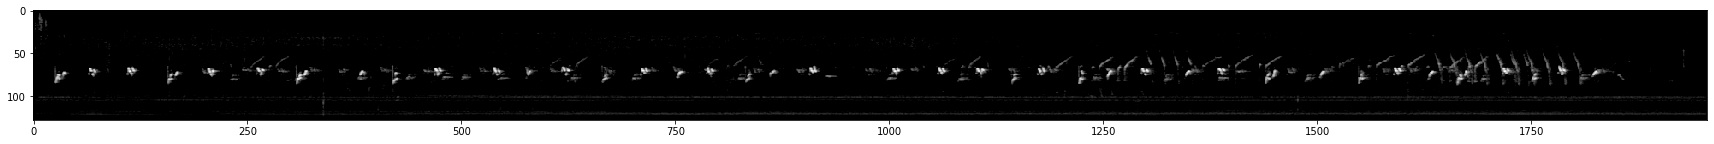

In [178]:
plt.figure(figsize=(30,4))
mel_spec_slow = librosa.filters.mel(sr, 2048).dot(np.abs(librosa.stft(audio))**2)
plt.imshow(librosa.amplitude_to_db(abs(mel_spec_slow)), cmap='gray')

In [22]:
from torch import nn

In [31]:
mel_filter_input = np.abs(librosa.stft(audio))**2

In [62]:
mel_conv_filter = nn.Conv1d(mel_filters.shape[1], mel_filters.shape[0], 1)

In [72]:
mel_conv_filter.weight.data[:,:,0] = torch.from_numpy(librosa.filters.mel(sr, 2048))

In [75]:
mel_filter_out = mel_conv_filter(torch.from_numpy(mel_filter_input.reshape(1, *mel_filter_input.shape)))

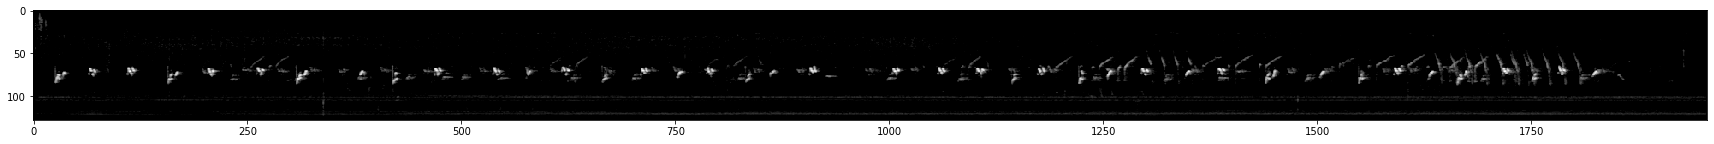

In [81]:
plt.figure(figsize=(30,4))
plt.imshow(librosa.amplitude_to_db(abs(mel_filter_out[0].detach())), cmap='gray')

In [30]:
list(mel_conv_filter.parameters())[0].shape

torch.Size([128, 1, 1025])

In [101]:
spec, y_pred = model(torch.from_numpy(audio.reshape(1,1,-1)).to(device).float())

In [102]:
spec_numpy = spec.squeeze(dim=0).cpu().detach().numpy()

In [103]:
spec_numpy.shape

(512, 3907)

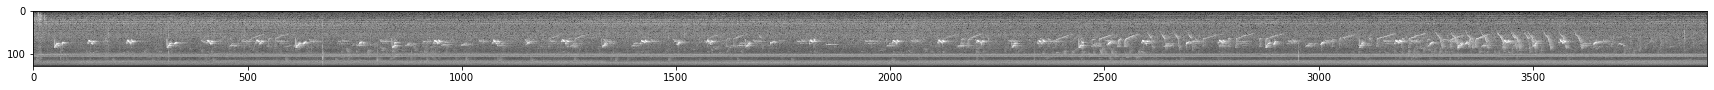

In [110]:
plt.figure(figsize=(30,4))
plt.imshow(librosa.filters.mel(22050, 1024)[:,1:].dot(spec_numpy), cmap='gray')

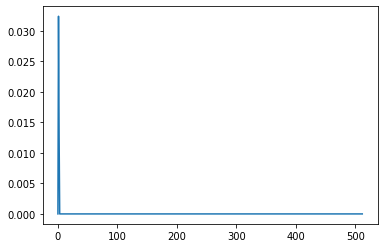

In [99]:
plt.plot(librosa.filters.mel(22050, 1024)[0])

In [68]:
# def get_std_thres(clip, sr, seconds_to_analyze = 1):
#     samples_to_analyse = int(sr*seconds_to_analyze)
#     croped_audio = samples_to_analyse*(len(clip)//samples_to_analyse)
#     stds = clip[:croped_audio].reshape(-1, samples_to_analyse).std(axis=1)
#     std_thres = np.mean(stds)
#     return std_thres

In [69]:
def get_cutted_acc(model, audio_fraction, fr, to):
    audio_fraction = audio_sample[fr*1024//4:to*1024//4]
    x_spec_conv, y_pred_conv = model(torch.tensor(audio_fraction.reshape(1, 1, -1)).float().to(device))

    y_pred_conv_softmax = torch.softmax(y_pred_conv, dim = 1)
    x_spec, y_pred = model(torch.tensor(audio_sample.reshape(1, 1, -1)).float().to(device))
    y_pred_softmax = torch.softmax(y_pred, dim = 1)
    idx_conv = np.argmax(y_pred_conv_softmax.detach().numpy())
    print('Recorte: ',classes[idx_conv], y_pred_conv_softmax[0][idx_conv].item())
    idx = np.argmax(y_pred_softmax.detach().numpy())

    plt.imshow(np.flipud(x_spec_conv.cpu().squeeze(0).detach()), cmap='gray')
    plt.show()
    print('Toda:', classes[idx], y_pred_softmax[0][idx].item())
    plt.imshow(np.flipud(x_spec.cpu().squeeze(0).detach()), cmap='gray')
    plt.show()

In [12]:
# sampled_au, fr, to = sample_audio_clip(total_audio, 5*sr, 1)
# plt.plot(sampled_au)

In [70]:
def get_std_thres(total_audio, seconds_to_analyze = 5, min_std=0.5, plot=True):
    samples_to_analyse = int(sr*seconds_to_analyze)
    croped_audio = samples_to_analyse*(len(total_audio)//samples_to_analyse)
    stds = total_audio[:croped_audio].reshape(-1, samples_to_analyse).std(axis=1)
    std_thres = np.mean(stds)
    if plot:
        plt.plot(total_audio, alpha=0.5)
        plt.hlines(min(stds), 0, len(total_audio))    
        plt.hlines(np.mean(stds), 0, len(total_audio))    
        plt.hlines(max(stds), 0, len(total_audio))    
        plt.show()
    return std_thres, total_audio.std()

for f in worst_files:
    total_audio = np.load(f)
    print(f, get_std_thres(total_audio))

NameError: name 'worst_files' is not defined

In [77]:
files_to_sample, classes_files = get_class_dataset(val_files, classes[0], N=2)

In [78]:
files_to_sample

['./dataset/bin_22050_librosa/aldfly/XC302253.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC137570.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC370881.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC323488.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC135457.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC247799.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC142066.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC189264.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC179417.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC178480.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC142065.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC195541.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC189592.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC140298.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC380033.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC135883.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC195542.mp3.bin',
 './dataset/bin_22050_librosa/aldfly/XC319017.mp

In [83]:
criterion = torch.nn.BCEWithLogitsLoss()

metric_by_class = {}
for i, cl in enumerate(classes):
    files_to_sample, classes_files = get_class_dataset(val_files, classes[0], N=6)
    print(i, cl, len(files_to_sample))
    validation_set = Dataset(files_to_sample, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=False)
    validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)
    avg_loss, avg_F1,  avg_acc = validate(model, validation_generator, criterion, device)
    metric_by_class[cl] = (avg_loss, avg_F1)
    print()

0 aldfly 120
2/2 - val loss: 0.013173289597034454, val F1 micro: 0.6120689511299133 val acc: 0.5916666388511658
1 ameavo 120
2/2 - val loss: 0.013356486335396767, val F1 micro: 0.5840708017349243 val acc: 0.550000011920929
2 amebit 120
2/2 - val loss: 0.014168966561555862, val F1 micro: 0.5666666626930237 val acc: 0.5666666626930237
3 amecro 120
2/2 - val loss: 0.014493442140519619, val F1 micro: 0.5941422581672668 val acc: 0.5916666388511658
4 amegfi 120
2/2 - val loss: 0.014470258727669716, val F1 micro: 0.5263158082962036 val acc: 0.56875
5 amekes 120
2/2 - val loss: 0.01497470773756504, val F1 micro: 0.522522509098053 val acc: 0.4833333194255829
6 amepip 120
2/2 - val loss: 0.01351842936128378, val F1 micro: 0.6160337328910828 val acc: 0.6083333492279053
7 amered 120
2/2 - val loss: 0.016024073585867882, val F1 micro: 0.5198237895965576 val acc: 0.49166667461395264
8 amerob 120
2/2 - val loss: 0.014029929414391518, val F1 micro: 0.5550661087036133 val acc: 0.5249999761581421
9 amew

In [115]:
# metric_by_class = np.load('metric_by_class.npy', allow_pickle=True).item()

In [93]:
classes_metrics = []
f1_metrics = []
for k, v in metric_by_class.items():
    classes_metrics.append(k)
    f1_metrics.append(v[1])

In [111]:
worst_indexes = np.argsort(f1_metrics)
worst_classes = list(zip(np.array(classes_metrics)[worst_indexes], np.array(f1_metrics)[worst_indexes]))
print(worst_classes[:10])

[('gockin', 0.48672565817832947), ('brthum', 0.49572649598121643), ('lesyel', 0.49789029359817505), ('fiespa', 0.5), ('pingro', 0.5), ('sposan', 0.5), ('buggna', 0.5065501928329468), ('comyel', 0.508474588394165), ('houfin', 0.5087719559669495), ('cliswa', 0.5089285969734192)]


In [113]:
classes_files[worst_classes[0][0]]

['./dataset/bin_22050_librosa/gockin/XC210903.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC381542.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC277109.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC351791.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC431933.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC173820.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC389432.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC135594.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC419363.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC134511.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC187642.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC419366.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC419365.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC146197.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC139626.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC350099.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC161125.mp3.bin',
 './dataset/bin_22050_librosa/gockin/XC389494.mp

In [142]:
Nf = 32
criterion = torch.nn.BCEWithLogitsLoss()
losses = []
for i, file in enumerate(classes_files[worst_classes[0][0]]):
    files_to_sample = [file]*Nf
    validation_set = Dataset(files_to_sample, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=False)
    validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)
    avg_loss, avg_F1,  avg_acc = validate(model, validation_generator, criterion, device)
    print(' - ',i+1, file)
    losses.append((file, avg_loss, avg_F1))

1/1 - val loss: 0.005847884342074394, val F1 micro: 0.5777778029441833 val acc: 0.40625 -  1 ./dataset/bin_22050_librosa/gockin/XC210903.mp3.bin
1/1 - val loss: 0.0024521828163415194, val F1 micro: 0.9152542352676392 val acc: 0.84375 -  2 ./dataset/bin_22050_librosa/gockin/XC381542.mp3.bin
1/1 - val loss: 0.0018719080835580826, val F1 micro: 0.8771929740905762 val acc: 0.78125 -  3 ./dataset/bin_22050_librosa/gockin/XC277109.mp3.bin
1/1 - val loss: 0.01539138425141573, val F1 micro: 0.30000001192092896 val acc: 0.1875 -  4 ./dataset/bin_22050_librosa/gockin/XC351791.mp3.bin
1/1 - val loss: 0.005397672299295664, val F1 micro: 0.5116279125213623 val acc: 0.34375 -  5 ./dataset/bin_22050_librosa/gockin/XC431933.mp3.bin
1/1 - val loss: 0.017513466998934746, val F1 micro: 0.17142857611179352 val acc: 0.09375 -  6 ./dataset/bin_22050_librosa/gockin/XC173820.mp3.bin
1/1 - val loss: 0.0031438088044524193, val F1 micro: 0.8771929740905762 val acc: 0.78125 -  7 ./dataset/bin_22050_librosa/gockin

In [174]:
file_losses = []
files_to_sort = []
for file, loss, f1 in losses:
    file_losses.append(loss)
    files_to_sort.append(file)
worst_files = list(zip(np.array(files_to_sort)[np.argsort(file_losses)[::-1]], np.array(file_losses)[np.argsort(file_losses)[::-1]]))

In [176]:
# worst_files

In [173]:
worst_files[0]

('./dataset/bin_22050_librosa/gockin/XC187642.mp3.bin', 0.03453725948929787)

In [177]:
files_to_sample = [worst_files[0][0]]*Nf
files_to_sample = ['./dataset/bin_22050_librosa/gockin/XC419363.mp3.bin']*Nf
validation_set = Dataset(files_to_sample, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=False)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)
for X, y in validation_generator:
    break

In [178]:
_, y_pred = model(X.float())

In [179]:
from birds_utils import multilabel_metrics

In [180]:
TP, FP, FN, micro_F1, total, T_total = multilabel_metrics(y_pred, y)

In [190]:
len(get_bin_audio(files_to_sample[0]))/sr

2.0894784580498866

In [21]:
np.save(f'worst_files_{sr}_ml_{worst_class}.npy', worst_files)


In [25]:
worst_files

array(['./dataset/npy_44100/amered/XC327739.mp3.npy',
       './dataset/npy_44100/amered/XC476576.mp3.npy',
       './dataset/npy_44100/amered/XC139439.mp3.npy',
       './dataset/npy_44100/amered/XC325262.mp3.npy',
       './dataset/npy_44100/amered/XC478597.mp3.npy',
       './dataset/npy_44100/amered/XC179362.mp3.npy',
       './dataset/npy_44100/amered/XC500093.mp3.npy',
       './dataset/npy_44100/amered/XC302517.mp3.npy',
       './dataset/npy_44100/amered/XC483145.mp3.npy',
       './dataset/npy_44100/amered/XC195834.mp3.npy',
       './dataset/npy_44100/amered/XC178310.mp3.npy',
       './dataset/npy_44100/amered/XC137604.mp3.npy',
       './dataset/npy_44100/amered/XC193127.mp3.npy',
       './dataset/npy_44100/amered/XC293013.mp3.npy',
       './dataset/npy_44100/amered/XC193128.mp3.npy'], dtype='<U43')

p: 0.09283729642629623


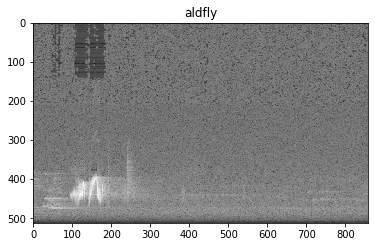

In [178]:
audio_sample = analyze_audio(model, worst_files[-1], classes, sr, duration, min_std, device)

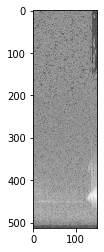

In [173]:
fr = 100
to = 250
plot_librosa_stft(audio_sample[fr*1024//4:to*1024//4], window_size, top_db=None)

In [249]:
import torch
from torch import nn
from torch.nn import functional as F
from birds_utils import get_fourier_weights, get_pytorch_model_all_conv

model = get_pytorch_model_all_conv(window_size, resnet='resnet18', pretrained=True, n_classes=10, init_fourier=True, train_fourier=False).to(device)


Using cache found in /Users/julian/.cache/torch/hub/pytorch_vision_v0.6.0


In [247]:
z_ = torch.zeros((1, 10))
z = torch.ones((1, 10))*-1
z_[0, 0] = 1
z[0, 0] = 1
nn.BCEWithLogitsLoss()(z*100, z_)

tensor(0.)

In [245]:
z

tensor([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

In [224]:
y_pred_conv

tensor([[ 0.7304, -0.4432, -0.8932, -2.6868,  0.7381,  0.8761, -0.0039, -0.7907,
          0.3534, -1.8746]], grad_fn=<ViewBackward>)

In [215]:
def model_to_all_conv():
    model_conv = get_pytorch_model_all_conv(window_size, resnet='resnet18', pretrained=True, n_classes=10, init_fourier=True, train_fourier=False)
    model_conv.cos.weight.data = model.cos.weight.data
    model_conv.sin.weight.data = model.sin.weight.data
    model_conv.cos.bias.data = model.cos.bias.data
    model_conv.sin.bias.data = model.sin.bias.data
    model_conv.resnet = model.resnet
    model_conv.conv_out.weight.data = model.fc1.weight.data.reshape(*model.fc1.weight.data.shape, 1, 1)
    model_conv.conv_out.bias.data = model.fc1.bias.data
    return model_conv

In [216]:
x_spec_conv, y_pred_conv = model_conv(torch.tensor(audio_fraction.reshape(1, 1, -1)).float().to(device))
y_pred_conv.shape
x_spec, y_pred = model(torch.tensor(audio_sample.reshape(1, 1, -1)).float().to(device))
y_pred_conv.shape, y_pred.shape

(torch.Size([1, 10]), torch.Size([1, 10]))

In [217]:
y_pred_conv.flatten(start_dim=1).shape

torch.Size([1, 10])

In [218]:
x_spec_conv, y_pred_conv = model_conv(torch.tensor(audio_fraction.reshape(1, 1, -1)).float().to(device))
y_pred_conv.shape

torch.Size([1, 10])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

p: 0.9997742772102356


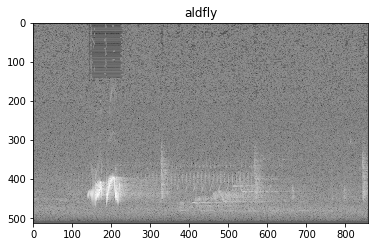

1.0490734220880338

In [219]:
audio_sample = analyze_audio(model, worst_files[-1], classes, sr, duration, min_std, device)
audio_sample.std()

Recorte:  aldfly 1.0


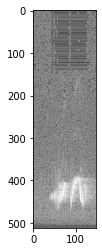

Toda: aldfly 0.9997742772102356


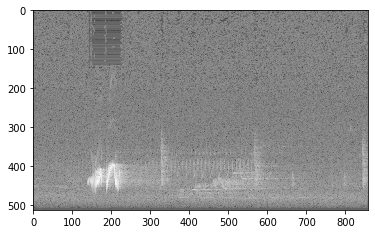

In [221]:
# x, conv_out = model_conv(torch.tensor(audio_sample[fr*1024//4:to*1024//4].reshape(1, 1, -1)).float().to(device))

def get_cutted_acc(audio_fraction, fr, to):
    audio_fraction = audio_sample[fr*1024//4:to*1024//4]
    x_spec_conv, y_pred_conv = model_conv(torch.tensor(audio_fraction.reshape(1, 1, -1)).float().to(device))

    y_pred_conv_softmax = torch.softmax(y_pred_conv, dim = 1)
    x_spec, y_pred = model(torch.tensor(audio_sample.reshape(1, 1, -1)).float().to(device))
    y_pred_softmax = torch.softmax(y_pred, dim = 1)
    idx_conv = np.argmax(y_pred_conv_softmax.detach().numpy())
    print('Recorte: ',classes[idx_conv], y_pred_conv_softmax[0][idx_conv].item())
    idx = np.argmax(y_pred_softmax.detach().numpy())

    plt.imshow(np.flipud(x_spec_conv.cpu().squeeze(0).detach()), cmap='gray')
    plt.show()
    print('Toda:', classes[idx], y_pred_softmax[0][idx].item())
    plt.imshow(np.flipud(x_spec.cpu().squeeze(0).detach()), cmap='gray')
    plt.show()


get_cutted_acc(audio_fraction, 100, 250)

In [151]:
y_pred_conv_softmax, y_pred_softmax

(tensor([[1.0000e+00, 8.5939e-24, 4.5673e-27, 1.1711e-25, 1.5754e-25, 1.3399e-23,
          5.1075e-20, 2.5123e-21, 2.5177e-26, 3.9579e-19]],
        grad_fn=<SoftmaxBackward>),
 tensor([[9.9996e-01, 1.1664e-06, 3.1689e-08, 6.1359e-09, 1.3240e-06, 1.7077e-05,
          7.7777e-06, 6.6449e-06, 1.4004e-06, 3.0307e-06]],
        grad_fn=<SoftmaxBackward>))

In [173]:
st = 44100*10
audio_sample_44100 = np.load('./dataset/npy_44100/balori/XC217802.mp3.npy')[44100*5:44100*5+44100*duration]
audio_sample_22050 = np.load('./dataset/npy_22050/balori/XC217802.mp3.npy')[22050*5:22050*5+22050*duration]

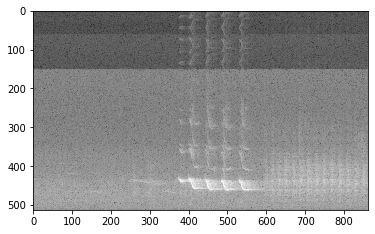

In [174]:
plot_librosa_stft(audio_sample_44100, window_size, top_db=None)

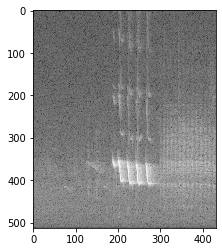

In [175]:
plot_librosa_stft(audio_sample_22050, window_size, top_db=None)

p: 0.06373637914657593


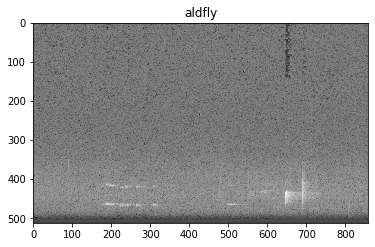

In [150]:
audio_sample = analyze_audio(model, './dataset/npy_44100/aldfly/XC189044.mp3.npy', classes, 44100, duration, min_std)

p: 0.9999980926513672


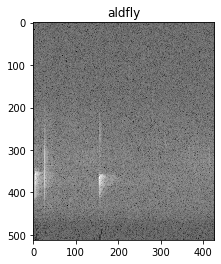

In [152]:
audio_sample = analyze_audio(model, './dataset/npy_22050/aldfly/XC189044.mp3.npy', classes, 22050, duration, min_std)

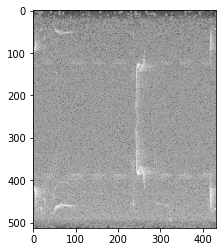

In [65]:
plot_librosa_stft(audio_sample, window_size, top_db=None)

In [82]:
audio_sample_1 = sample_audio_clip(np.load(worst_files[0]), duration*sr, 0.5).reshape(1, -1)
audio_sample_2 = sample_audio_clip(np.load(worst_files[0]), duration*sr, 0.5).reshape(1, -1)
audio_sample_3 = sample_audio_clip(np.load(worst_files[0]), duration*sr, 0.5).reshape(1, -1)
audio_sample_4 = sample_audio_clip(np.load(worst_files[0]), duration*sr, 0.5).reshape(1, -1)

In [85]:
net_input = np.concatenate([audio_sample_1, audio_sample_2, audio_sample_3, audio_sample_4]).reshape(2, 2, -1)

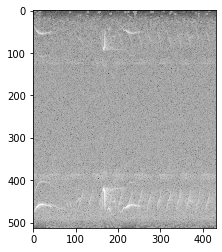

In [94]:
plot_librosa_stft(net_input[0, 1], window_size, top_db=None)

In [151]:
audio = np.load(wost_files[-1])
audio_sample = sample_audio_clip(audio, sr*duration, 0.5)


In [156]:
audio = np.load(wost_files[2])
audio_sample = sample_audio_clip(audio, sr*duration, 0.5)
ipd.Audio(audio_sample, rate=22050)

In [60]:
print(np.array(accs)[np.argsort(losses)[::-1]])
worst_files = np.array(classes_files[worst_class])[np.argsort(losses)[::-1]]

[0.         0.         0.0625     0.25       0.24609375 0.421875
 0.70703125 0.7578125  0.8046875  0.80859375 0.91796875 0.859375
 0.94921875 0.9453125  0.984375   0.9921875  0.98828125 1.
 1.         1.         1.         1.        ]


In [61]:
audio = np.load(worst_files[2])
ipd.Audio(audio, rate=22050)

In [135]:

ipd.Audio(audio, rate=22050)

In [85]:
validation_generator = get_class_dataset('balori', N=10)
loss, acc = validate_model_acc_loss(model, validation_generator, criterion, device)

7/7 - val loss: 1.7684855461120605, val acc: 0.7045454382896423

In [113]:
loss, acc, Xs, ys, y_preds, losses = validate_model_loss_detail(model, validation_generator, torch.nn.CrossEntropyLoss(reduction='none'), device)
Xs_ = torch.cat(Xs).detach().numpy()
ys_ = torch.cat(ys).detach().numpy()
losses_ = torch.cat(losses).cpu().detach().numpy()
y_preds_ = torch.cat(y_preds).cpu().detach().numpy()

7/7 - val loss: 1.6962859630584717, val acc: 0.7545454502105713

In [101]:
Xs.shape, ys.shape, y_preds.shape, losses.shape

(torch.Size([220, 1, 110250]),
 torch.Size([220]),
 torch.Size([220, 10]),
 torch.Size([220]))

In [84]:
torch.nn.CrossEntropyLoss(reduction='none')(y_preds[0].cuda(), ys[0].cuda())

tensor([9.2122e-01, 4.2620e+00, 2.9421e-01, 1.5501e-01, 6.6757e-06, 4.6323e+00,
        4.8780e-02, 9.8625e-01, 3.2568e-04, 5.7220e-06, -0.0000e+00, 1.5259e-05,
        6.1569e+00, -0.0000e+00, 1.0123e-01, 7.1071e+00, 6.8959e+00, 1.1736e+01,
        2.0218e-04, 6.2476e+00, 3.8147e-06, 3.0251e-03, 1.9073e-06, 1.9741e-04,
        7.9911e+00, 2.0000e-02, 7.3298e+00, 8.8778e-02, 1.3741e+00, 1.1940e-03,
        3.1471e-05, 6.0196e+00], device='cuda:0')

In [ ]:
audio = np.load(wors)

In [ ]:
spec, y_pred = model(torch.tensor(audio_sample.reshape(1, 1, -1)).float().cuda())

In [62]:
worst_files

array(['./dataset/npy_22050/balori/XC329040.mp3.npy',
       './dataset/npy_22050/balori/XC322444.mp3.npy',
       './dataset/npy_22050/balori/XC415889.mp3.npy',
       './dataset/npy_22050/balori/XC323704.mp3.npy',
       './dataset/npy_22050/balori/XC217806.mp3.npy',
       './dataset/npy_22050/balori/XC367802.mp3.npy',
       './dataset/npy_22050/balori/XC476519.mp3.npy',
       './dataset/npy_22050/balori/XC217753.mp3.npy',
       './dataset/npy_22050/balori/XC367801.mp3.npy',
       './dataset/npy_22050/balori/XC331558.mp3.npy',
       './dataset/npy_22050/balori/XC216100.mp3.npy',
       './dataset/npy_22050/balori/XC335644.mp3.npy',
       './dataset/npy_22050/balori/XC315312.mp3.npy',
       './dataset/npy_22050/balori/XC368438.mp3.npy',
       './dataset/npy_22050/balori/XC367800.mp3.npy',
       './dataset/npy_22050/balori/XC333620.mp3.npy',
       './dataset/npy_22050/balori/XC375494.mp3.npy',
       './dataset/npy_22050/balori/XC313533.mp3.npy',
       './dataset/npy_22050/

In [ ]:
model